In [9]:
import pyreadr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.linear_model import LassoCV, LogisticRegressionCV

from doubleml.data import DoubleMLPanelData
from doubleml.did import DoubleMLDIDMulti
import warnings

warnings.filterwarnings('ignore')

# Download and process data

In [16]:
mpdta = pd.read_parquet('/Users/mcargnel/Documents/mea/tesis/data/mpdta.parquet')
mpdta.head()

,year,countyreal,lpop,lemp,first.treat,treat
0,2003,8001.0,5.896761,8.461469,2007.0,1.0
1,2004,8001.0,5.896761,8.336870,2007.0,1.0
2,2005,8001.0,5.896761,8.340217,2007.0,1.0
3,2006,8001.0,5.896761,8.378161,2007.0,1.0
4,2007,8001.0,5.896761,8.487352,2007.0,1.0


In [28]:
# Set values for treatment group indicator for never-treated to np.inf
mpdta.loc[mpdta['first.treat'] == 0, 'first.treat'] = np.inf

In [ ]:
dml_data = DoubleMLPanelData(
    data=mpdta,
    y_col="lemp", # log teen employement
    d_cols="first.treat", # treatment, is minimun wage
    id_col="countyreal", # counties
    t_col="year",
    x_cols=['lpop'] # log of county population, should be time invariant
)
print(dml_data)

================== DoubleMLPanelData Object ==================

------------------ Data summary      ------------------
Outcome variable: lemp
Treatment variable(s): ['first.treat']
Covariates: ['lpop']
Instrument variable(s): None
Time variable: year
Id variable: countyreal
No. Unique Ids: 500
No. Observations: 2500

------------------ DataFrame info    ------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Columns: 6 entries, year to treat
dtypes: float64(5), int32(1)
memory usage: 107.6 KB



# ATT Estimation: Unconditional Parallel Trends

In [93]:
dml_obj = DoubleMLDIDMulti(
    obj_dml_data=dml_data,
    ml_g=DummyRegressor(),
    ml_m=DummyClassifier(),
    control_group="never_treated",
    n_folds=10
)

dml_obj.fit()

print(dml_obj.summary.round(4))

                         coef  std err       t   P>|t|   2.5 %  97.5 %
ATT(2004.0,2003,2004) -0.0105   0.0231 -0.4543  0.6496 -0.0558  0.0348
ATT(2004.0,2003,2005) -0.0704   0.0310 -2.2699  0.0232 -0.1311 -0.0096
ATT(2004.0,2003,2006) -0.1373   0.0363 -3.7786  0.0002 -0.2085 -0.0661
ATT(2004.0,2003,2007) -0.1008   0.0347 -2.9073  0.0036 -0.1687 -0.0328
ATT(2006.0,2003,2004)  0.0065   0.0234  0.2790  0.7803 -0.0393  0.0524
ATT(2006.0,2004,2005) -0.0027   0.0195 -0.1410  0.8879 -0.0409  0.0354
ATT(2006.0,2005,2006) -0.0046   0.0178 -0.2573  0.7969 -0.0395  0.0304
ATT(2006.0,2005,2007) -0.0412   0.0202 -2.0374  0.0416 -0.0809 -0.0016
ATT(2007.0,2003,2004)  0.0305   0.0151  2.0225  0.0431  0.0009  0.0600
ATT(2007.0,2004,2005) -0.0028   0.0164 -0.1679  0.8667 -0.0349  0.0294
ATT(2007.0,2005,2006) -0.0311   0.0179 -1.7369  0.0824 -0.0661  0.0040
ATT(2007.0,2006,2007) -0.0260   0.0167 -1.5605  0.1186 -0.0587  0.0067


In [62]:
level = 0.95

ci = dml_obj.confint(level=level)
dml_obj.bootstrap(n_rep_boot=5000)
ci_joint = dml_obj.confint(level=level, joint=True)
print(ci_joint)

                          2.5 %    97.5 %
ATT(2004.0,2003,2004) -0.075970  0.054898
ATT(2004.0,2003,2005) -0.157507  0.016611
ATT(2004.0,2003,2006) -0.240617 -0.033939
ATT(2004.0,2003,2007) -0.198931 -0.002892
ATT(2006.0,2003,2004) -0.059533  0.072582
ATT(2006.0,2004,2005) -0.058220  0.052738
ATT(2006.0,2005,2006) -0.055153  0.045927
ATT(2006.0,2005,2007) -0.098463  0.015939
ATT(2007.0,2003,2004) -0.012057  0.073134
ATT(2007.0,2004,2005) -0.049130  0.043599
ATT(2007.0,2005,2006) -0.081565  0.019570
ATT(2007.0,2006,2007) -0.073126  0.021084


================== DoubleMLDIDAggregation Object ==================
 Event Study Aggregation 

------------------ Overall Aggregated Effects ------------------
     coef  std err        t    P>|t|     2.5 %    97.5 %
-0.077274 0.020061 -3.85193 0.000117 -0.116593 -0.037955
------------------ Aggregated Effects         ------------------
          coef   std err         t     P>|t|     2.5 %    97.5 %
-3.0  0.030538  0.015074  2.025852  0.042780  0.000993  0.060083
-2.0 -0.000593  0.013302 -0.044544  0.964471 -0.026664  0.025479
-1.0 -0.024388  0.014224 -1.714505  0.086436 -0.052267  0.003492
0.0  -0.019916  0.011819 -1.685153  0.091959 -0.043080  0.003248
1.0  -0.050990  0.016768 -3.040946  0.002358 -0.083855 -0.018126
2.0  -0.137278  0.036571 -3.753723  0.000174 -0.208956 -0.065600
3.0  -0.100911  0.034688 -2.909076  0.003625 -0.168900 -0.032923
------------------ Additional Information     ------------------
Score function: observational
Control group: never_treated
Anticipation peri

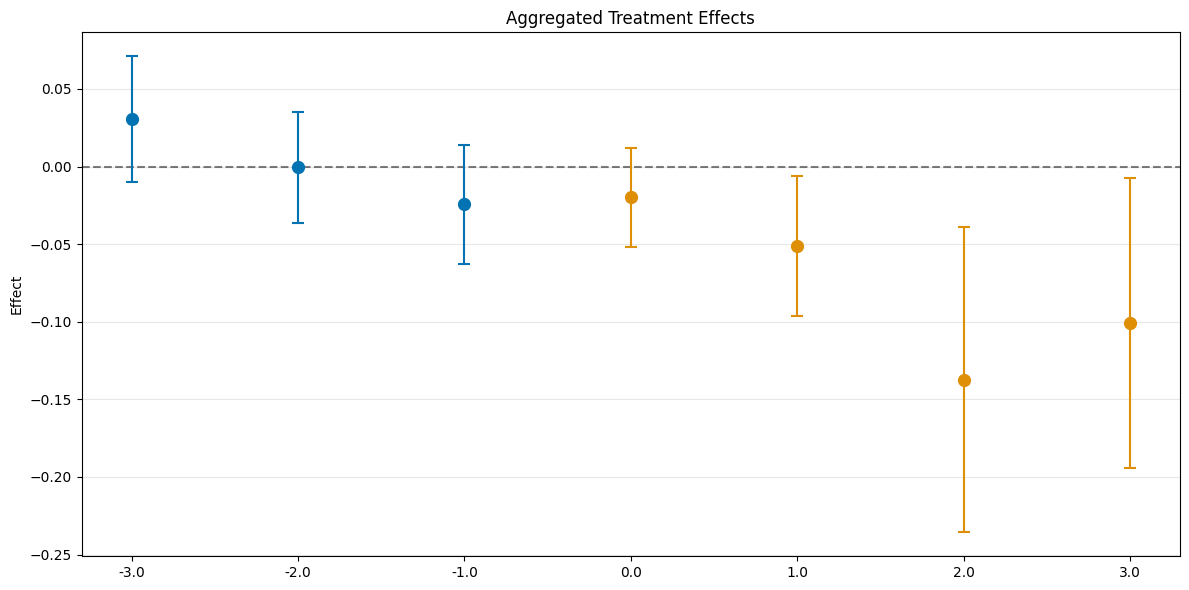

In [72]:
# rerun bootstrap for valid simultaneous inference (as values are not saved)
dml_obj.bootstrap(n_rep_boot=5000)
aggregated_eventstudy = dml_obj.aggregate("eventstudy")
# run bootstrap to obtain simultaneous confidence intervals
aggregated_eventstudy.aggregated_frameworks.bootstrap()
print(aggregated_eventstudy)
fig, ax = aggregated_eventstudy.plot_effects()

In [8]:
aggregated_eventstudy.aggregation_weights[2]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.23391813, 0.        , 0.        , 0.        , 0.        ,
       0.76608187, 0.        ])

In [9]:
dml_obj_linear_logistic = DoubleMLDIDMulti(
    obj_dml_data=dml_data,
    ml_g=LinearRegression(),
    ml_m=LogisticRegression(penalty=None),
    control_group="never_treated",
    n_folds=10
)

In [10]:
dml_obj_linear_logistic.fit()

/Users/mcargnel/Documents/mea/tesis/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/mcargnel/Documents/mea/tesis/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/mcargnel/Documents/mea/tesis/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/mcargnel/Documents/mea/tesis/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/mcargnel/Documents/mea/tesis/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation

/Users/mcargnel/Documents/mea/tesis/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/mcargnel/Documents/mea/tesis/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/mcargnel/Documents/mea/tesis/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/mcargnel/Documents/mea/tesis/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/mcargnel/Documents/mea/tesis/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation

(<Figure size 1200x800 with 4 Axes>,
 [<Axes: title={'center': 'First Treated: 2004.0'}, ylabel='Effect'>,
  <Axes: title={'center': 'First Treated: 2006.0'}, ylabel='Effect'>,
  <Axes: title={'center': 'First Treated: 2007.0'}, xlabel='Evaluation Period', ylabel='Effect'>])

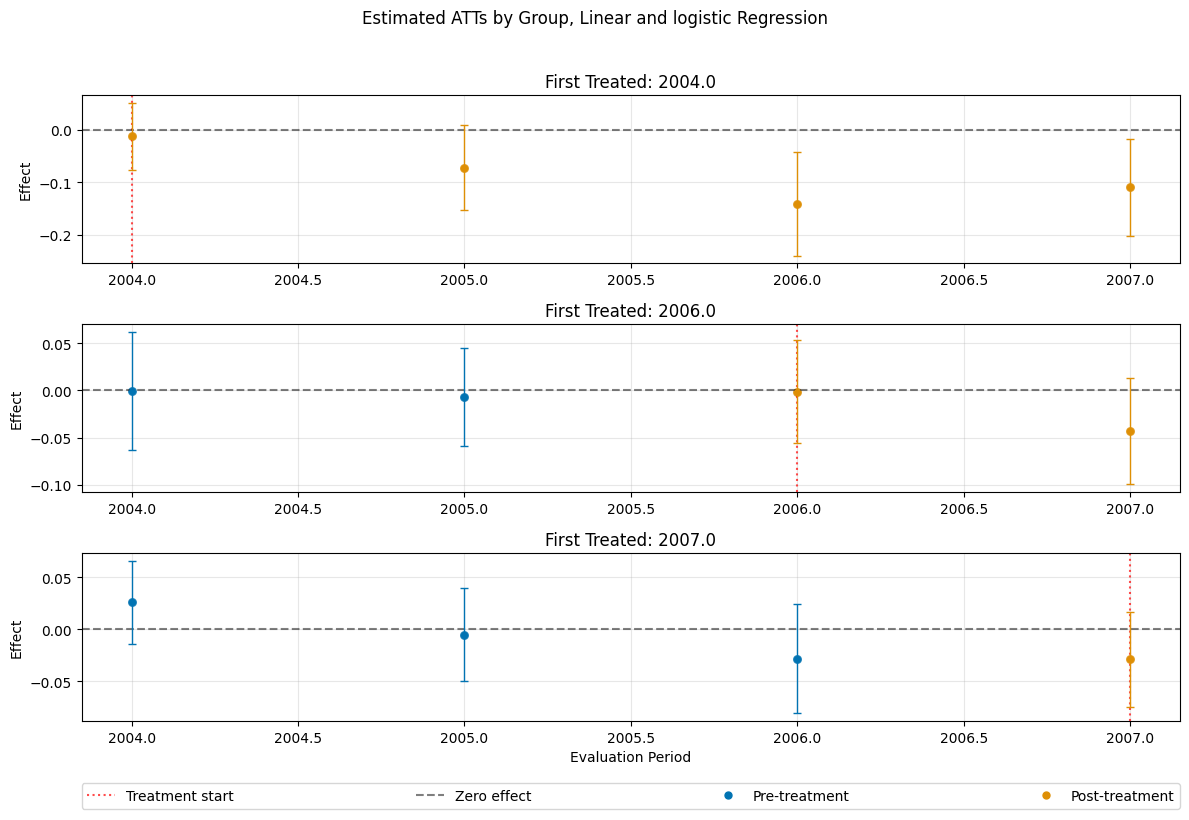

In [11]:
dml_obj_linear_logistic.fit()
dml_obj_linear_logistic.bootstrap(n_rep_boot=5000)
dml_obj_linear_logistic.plot_effects(title="Estimated ATTs by Group, Linear and logistic Regression")


In [12]:
print(dml_obj_linear_logistic)

================== DoubleMLDIDMulti Object ==================

------------------ Data summary      ------------------
Outcome variable: lemp
Treatment variable(s): ['first.treat']
Covariates: ['lpop']
Instrument variable(s): None
Time variable: year
Id variable: countyreal
No. Unique Ids: 500
No. Observations: 2500

------------------ Score & algorithm ------------------
Score function: observational
Control group: never_treated
Anticipation periods: 0

------------------ Machine learner   ------------------
Learner ml_g: LinearRegression()
Learner ml_m: LogisticRegression(penalty=None)
Out-of-sample Performance:
Regression:
Learner ml_g0 RMSE: [[0.17240948 0.18196096 0.25815903 0.25846726 0.17224056 0.15144947
  0.20119291 0.2070697  0.17273855 0.1519494  0.20115347 0.16325971]]
Learner ml_g1 RMSE: [[0.09864654 0.13035573 0.14387363 0.1520511  0.14186967 0.11430649
  0.0866984  0.10668448 0.13754288 0.16120392 0.16088808 0.16266943]]
Classification:
Learner ml_m Log Loss: [[0.2305854

(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Estimated ATTs by Group, Linear and logistic Regression'}, ylabel='Effect'>)

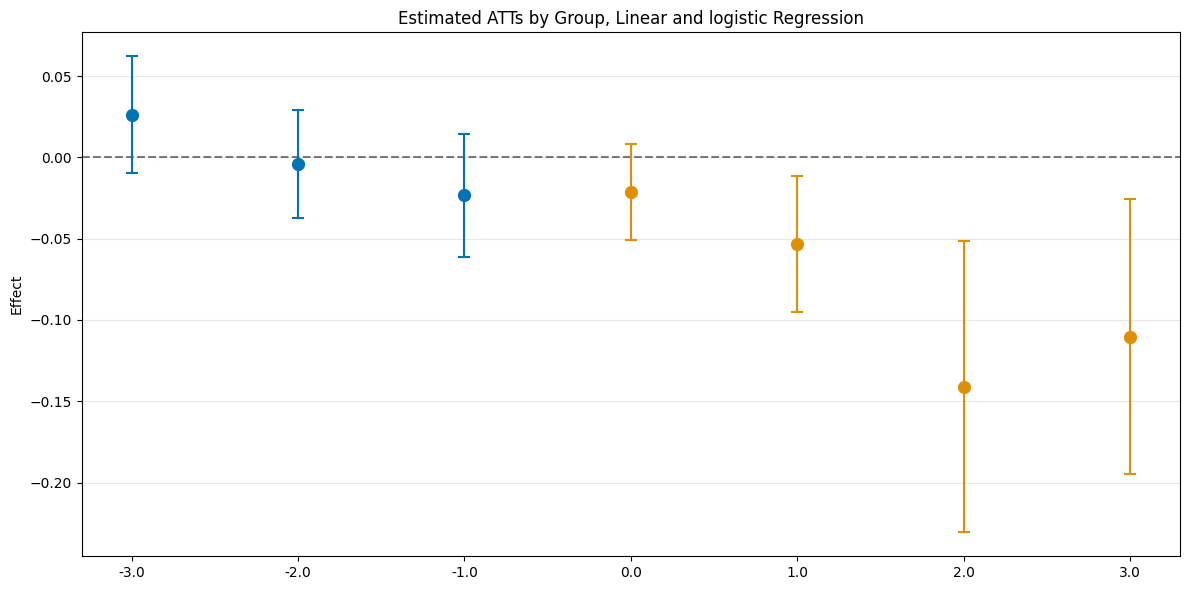

In [13]:
es_linear_logistic = dml_obj_linear_logistic.aggregate("eventstudy")
es_linear_logistic.aggregated_frameworks.bootstrap()
es_linear_logistic.plot_effects(title="Estimated ATTs by Group, Linear and logistic Regression")

/Users/mcargnel/Documents/mea/tesis/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/mcargnel/Documents/mea/tesis/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/mcargnel/Documents/mea/tesis/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/mcargnel/Documents/mea/tesis/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/mcargnel/Documents/mea/tesis/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation

(<Figure size 1200x800 with 4 Axes>,
 [<Axes: title={'center': 'First Treated: 2004.0'}, ylabel='Effect'>,
  <Axes: title={'center': 'First Treated: 2006.0'}, ylabel='Effect'>,
  <Axes: title={'center': 'First Treated: 2007.0'}, xlabel='Evaluation Period', ylabel='Effect'>])

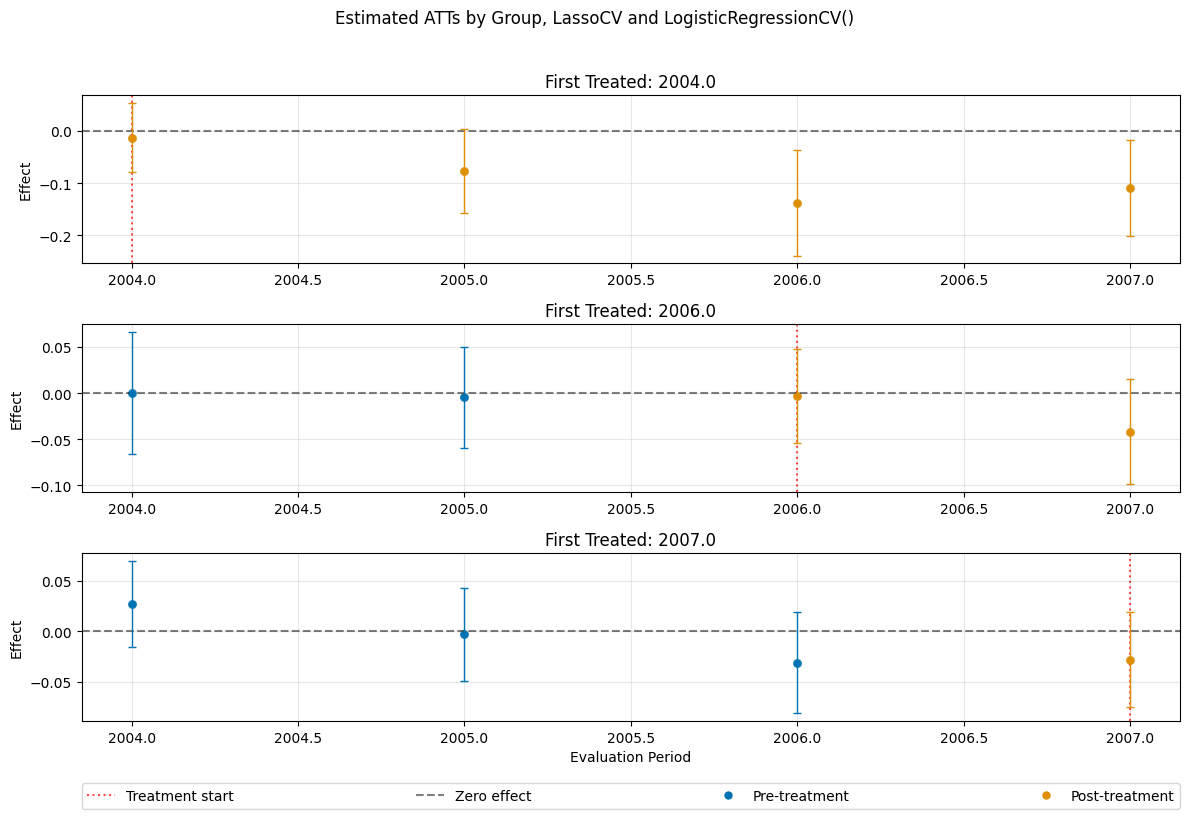

In [14]:
dml_obj_lasso = DoubleMLDIDMulti(
    obj_dml_data=dml_data,
    ml_g=LassoCV(),
    ml_m=LogisticRegressionCV(),
    control_group="never_treated",
    n_folds=10
)

dml_obj_lasso.fit()
dml_obj_lasso.bootstrap(n_rep_boot=5000)
dml_obj_lasso.plot_effects(title="Estimated ATTs by Group, LassoCV and LogisticRegressionCV()")

In [15]:
# Model summary
print(dml_obj_lasso)    

================== DoubleMLDIDMulti Object ==================

------------------ Data summary      ------------------
Outcome variable: lemp
Treatment variable(s): ['first.treat']
Covariates: ['lpop']
Instrument variable(s): None
Time variable: year
Id variable: countyreal
No. Unique Ids: 500
No. Observations: 2500

------------------ Score & algorithm ------------------
Score function: observational
Control group: never_treated
Anticipation periods: 0

------------------ Machine learner   ------------------
Learner ml_g: LassoCV()
Learner ml_m: LogisticRegressionCV()
Out-of-sample Performance:
Regression:
Learner ml_g0 RMSE: [[0.1723612  0.18173844 0.25865003 0.25919199 0.17203609 0.15269035
  0.20179461 0.20577975 0.17289341 0.15151837 0.20111881 0.16393302]]
Learner ml_g1 RMSE: [[0.10129071 0.12693345 0.1395581  0.15547554 0.14022759 0.10879794
  0.08681502 0.10564478 0.13308008 0.16054982 0.15848244 0.16084576]]
Classification:
Learner ml_m Log Loss: [[0.22913436 0.22913676 0.2291

(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Estimated ATTs by Group, LassoCV and LogisticRegressionCV()'}, ylabel='Effect'>)

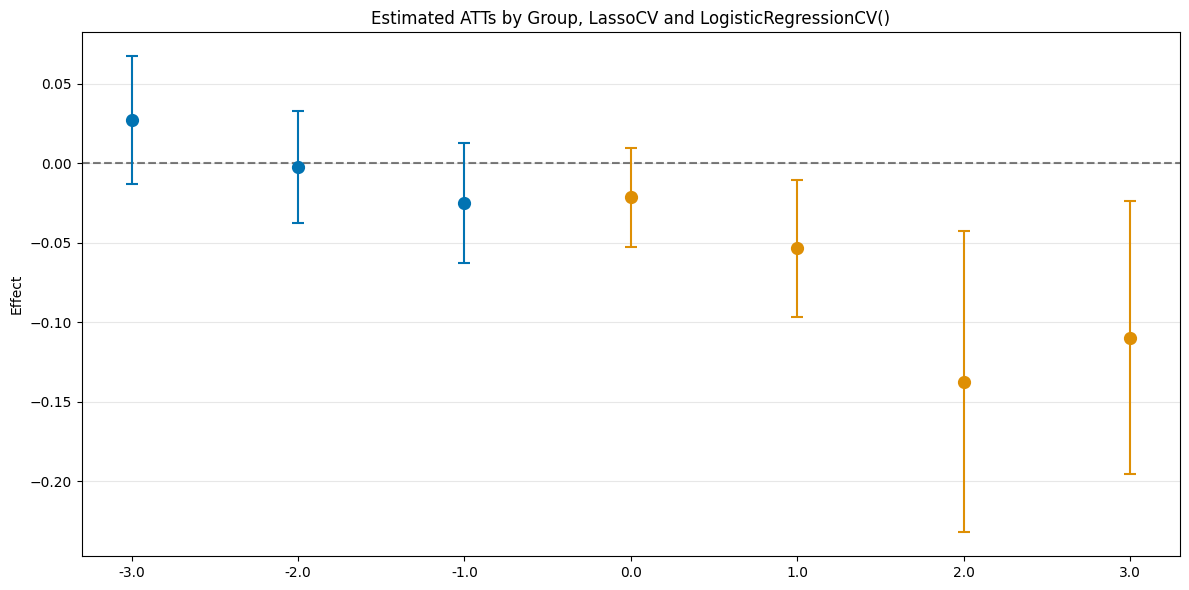

In [16]:
es_rf = dml_obj_lasso.aggregate("eventstudy")
es_rf.aggregated_frameworks.bootstrap()
es_rf.plot_effects(title="Estimated ATTs by Group, LassoCV and LogisticRegressionCV()")